In [1]:
#!python -m spacy download en_core_web_sm

import spacy
import pandas as pd
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

csvpath = 'C:/Users/andre/OneDrive/Work/Georgetown RA/Joshi-DeJure/0_data/interim/CleanedGptFull.csv'
cleanedGpt = pd.read_csv(csvpath)


#Load India administrative level data
indiaAdmin = pd.read_excel('C:/Users/andre/OneDrive/Work/Georgetown RA/Joshi-DeJure/0_data/interim/India_Districts_Transformed.xlsx')

# Create sets for quick lookup (from the cleaned data)
india_districts_set = set(indiaAdmin['Districts'].str.lower())
india_states_set = set(indiaAdmin['State/Union Territory'].str.lower())
outputcsvPath = 'C:/Users/andre/OneDrive/Work/Georgetown RA/Joshi-DeJure/0_data/interim/NER.csv'




In [2]:
# Function to extract locations using spaCy
def extract_locations_spacy(text):
    doc = nlp(str(text))
    return [ent.text for ent in doc.ents if ent.label_ == 'GPE']

# Apply the function to the 'location' column of your DataFrame
cleanedGpt['extracted_locations_spacy'] = cleanedGpt['location'].apply(extract_locations_spacy)

# Function to categorize and tag locations
def categorize_and_tag(entities):
    categorized = {'State': [], 'District': []}
    for entity in entities:
        entity_lower = entity.lower()
        if entity_lower in india_states_set:
            categorized['State'].append(entity)
        elif entity_lower in india_districts_set:
            categorized['District'].append(entity)
    return categorized

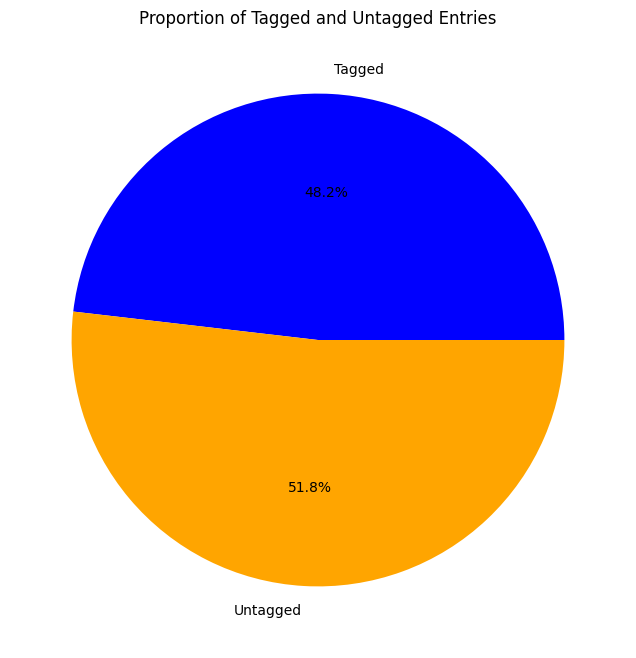

In [3]:
# Apply the categorizing function
cleanedGpt['categorized_locations'] = cleanedGpt['extracted_locations_spacy'].apply(categorize_and_tag)

# Create new columns for each administrative level
cleanedGpt['State'] = cleanedGpt['categorized_locations'].apply(lambda x: x.get('State', None))
cleanedGpt['District'] = cleanedGpt['categorized_locations'].apply(lambda x: x.get('District', None))

# Visualize the tagging proportion
tagged_count = cleanedGpt['extracted_locations_spacy'].apply(lambda x: len(x) > 0).sum()
untagged_count = len(cleanedGpt) - tagged_count

# Data for plotting
labels = ['Tagged', 'Untagged']
sizes = [tagged_count, untagged_count]
colors = ['blue', 'orange']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Proportion of Tagged and Untagged Entries')
plt.show()

cleanedGpt.to_csv(outputcsvPath, index=False)
